In [781]:
import time

import IPython
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import metrics
import torch

from src.plot_utils import plot_feature, plot_groupby, crossplot_pred
from src.train_utils import create_dataloader # , TimeSeriesTransformer

In [2]:
%load_ext autoreload
%autoreload 2

### Main block

[Exploratory data analysis](#Exploratory-data-analysis)<br>
[Problem statement](#Problem-statement)<br>
[Data preprocessing](#Data-preprocessing)<br>
[Baseline Model](#Baseline-model)<br>
[Transformers](#Transformers)<br>
[Сonclusions](#Conclusions)<br>

## Exploratory data analysis

In [3]:
data_path = './data/data.csv'

In [4]:
df = pd.read_csv(data_path)

In [5]:
df.head(10)

,id,cycle,p00,p01,p02,p03,p04,p05,p06,p07,...,p13,p14,p15,p16,p17,p18,p19,p20,s1,s2
0,1,1,518.67,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,...,23.4190,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,-0.0007,-0.0004
1,1,2,518.67,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,...,23.4236,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,0.0019,-0.0003
2,1,3,518.67,1.3,47.27,522.42,2388.03,8133.23,8.4178,0.03,...,23.3442,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,-0.0043,0.0003
3,1,4,518.67,1.3,47.13,522.86,2388.08,8133.83,8.3682,0.03,...,23.3739,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,0.0007,0.0000
4,1,5,518.67,1.3,47.28,522.19,2388.04,8133.80,8.4294,0.03,...,23.4044,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,-0.0019,-0.0002
5,1,6,518.67,1.3,47.16,521.68,2388.03,8132.85,8.4108,0.03,...,23.3669,1584.47,1398.37,14.62,21.61,554.67,2388.02,9049.68,-0.0043,-0.0001
6,1,7,518.67,1.3,47.36,522.32,2388.03,8132.32,8.3974,0.03,...,23.3774,1592.32,1397.77,14.62,21.61,554.34,2388.02,9059.13,0.0010,0.0001
7,1,8,518.67,1.3,47.24,522.47,2388.03,8131.07,8.4076,0.03,...,23.3106,1582.96,1400.97,14.62,21.61,553.85,2388.00,9040.80,-0.0034,0.0003
8,1,9,518.67,1.3,47.29,521.79,2388.05,8125.69,8.3728,0.03,...,23.4066,1590.98,1394.80,14.62,21.61,553.69,2388.05,9046.46,0.0008,0.0001
9,1,10,518.67,1.3,47.03,521.79,2388.06,8129.38,8.4286,0.03,...,23.4694,1591.24,1400.46,14.62,21.61,553.59,2388.05,9051.70,-0.0033,0.0001


In [6]:
df.tail(10)

,id,cycle,p00,p01,p02,p03,p04,p05,p06,p07,...,p13,p14,p15,p16,p17,p18,p19,p20,s1,s2
16128,80,176,518.67,1.3,47.92,521.08,2388.20,8204.48,8.5111,0.03,...,23.1720,1600.14,1428.42,14.62,21.61,552.11,2388.12,9139.28,0.0014,0.0001
16129,80,177,518.67,1.3,48.07,520.15,2388.11,8206.52,8.4967,0.03,...,23.0713,1603.93,1423.61,14.62,21.61,551.94,2388.17,9143.78,-0.0004,0.0004
16130,80,178,518.67,1.3,48.12,520.80,2388.18,8216.30,8.5173,0.03,...,23.1038,1603.07,1420.15,14.62,21.61,551.81,2388.09,9149.03,0.0000,0.0000
16131,80,179,518.67,1.3,48.06,520.50,2388.10,8211.19,8.4860,0.03,...,23.1907,1613.29,1432.42,14.62,21.61,551.59,2388.15,9144.00,-0.0006,-0.0003
16132,80,180,518.67,1.3,48.03,520.01,2388.12,8215.84,8.5194,0.03,...,23.0692,1602.87,1422.70,14.62,21.61,551.54,2388.17,9155.94,0.0005,-0.0002
16133,80,181,518.67,1.3,48.17,520.44,2388.17,8218.63,8.5194,0.03,...,23.1678,1604.26,1428.92,14.62,21.61,552.24,2388.20,9145.62,0.0042,0.0002
16134,80,182,518.67,1.3,48.41,520.06,2388.12,8221.91,8.5493,0.03,...,23.0142,1598.32,1426.31,14.62,21.61,551.60,2388.16,9160.23,-0.0014,0.0004
16135,80,183,518.67,1.3,48.04,519.67,2388.21,8217.46,8.5106,0.03,...,22.9337,1603.37,1434.30,14.62,21.61,551.78,2388.12,9152.84,0.0018,0.0000
16136,80,184,518.67,1.3,48.04,519.72,2388.20,8228.65,8.4983,0.03,...,22.9971,1603.01,1430.23,14.62,21.61,551.78,2388.17,9164.10,-0.0024,0.0002
16137,80,185,518.67,1.3,48.05,520.00,2388.18,8229.73,8.5250,0.03,...,23.0323,1606.38,1421.41,14.62,21.61,551.55,2388.22,9170.57,0.0015,0.0000


In [7]:
# Let's look unique id of timeseries in dataset
df.id.unique().shape 

(80,)

Try to find constant features. Each p-th and s-th element of dataset is float number. I don't want to use `unique` function for floats so we could calculate std to find a zero.

In [8]:
df.std()

id       2.339535e+01
cycle    6.591530e+01
p00      0.000000e+00
p01      2.220515e-16
p02      2.674218e-01
p03      7.382523e-01
p04      7.260372e-02
p05      1.973135e+01
p06      3.751962e-02
p07      1.387822e-17
p08      1.549031e+00
p09      0.000000e+00
p10      0.000000e+00
p11      5.007111e-01
p12      1.810428e-01
p13      1.086055e-01
p14      6.129960e+00
p15      8.977073e+00
p16      3.552824e-15
p17      1.417433e-03
p18      8.879473e-01
p19      7.160782e-02
p20      2.278136e+01
s1       2.188188e-03
s2       2.939096e-04
dtype: float64

`p00`, `p09`, `p10` are constant values and could be removed from dataset without loss of information. <br>
`p01`, `p07`, `p16` have a std is very close to zero, so it looks like a contant values. A non-zero value of std is an error of float calculation.

Text(0.5, 1.0, 'Max cycle of timeseries. min: 128, max: 362')

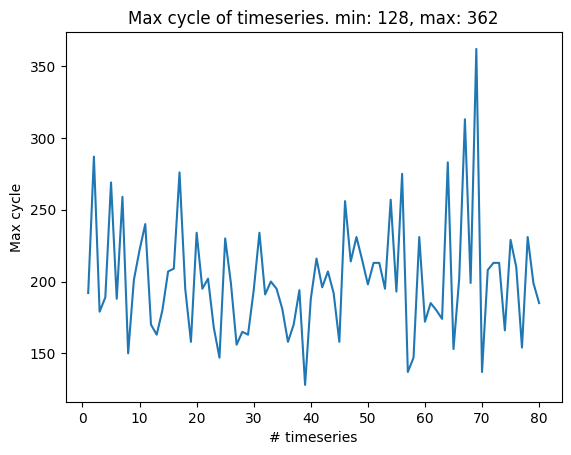

In [9]:
cycle_max = df.groupby(by='id')['cycle'].max()
plt.plot(cycle_max)
plt.xlabel('# timeseries')
plt.ylabel('Max cycle')
plt.title(f'Max cycle of timeseries. min: {cycle_max.min()}, max: {cycle_max.max()}')

Split the dataset by timeseries and look for statistsics by each timeseries.

There are a lot of numbers. Let's visualize it.

In [10]:
df_drop = df.drop(['p00', 'p01', 'p07', 'p09', 'p10', 'p16'], axis=1)

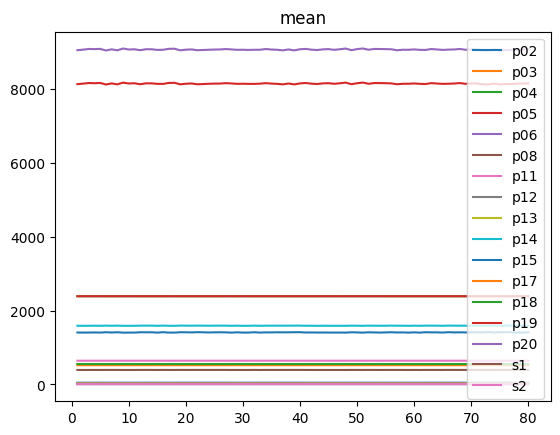

In [11]:
plot_groupby(df_drop, 'mean', show_labels=True)

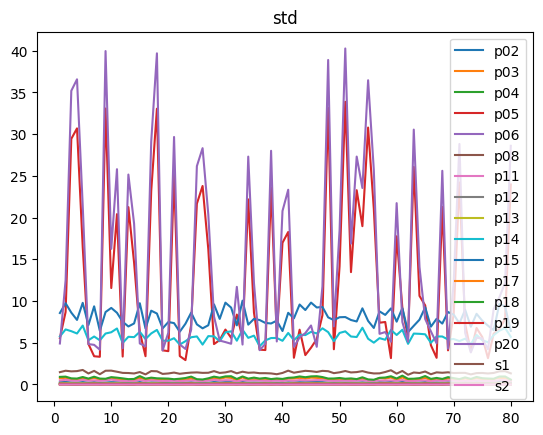

In [12]:
plot_groupby(df_drop, 'std', show_labels=True)

Text(0.5, 1.0, 'p20 range of timeseries. min: 19.140, max: 188.170')

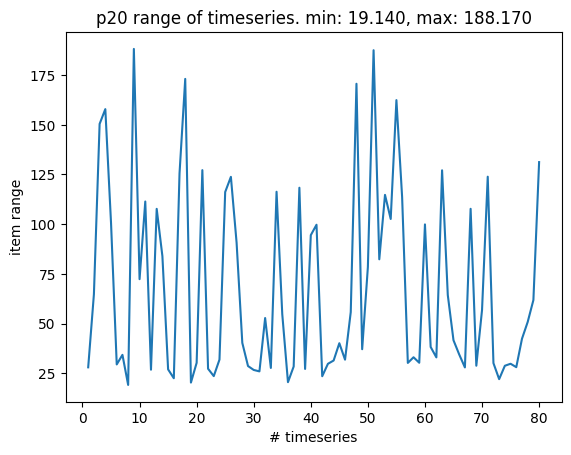

In [938]:
item = 'p20'
item_range = df.groupby(by='id')[item].max() - df.groupby(by='id')[item].min()
plt.plot(item_range)
plt.xlabel('# timeseries')
plt.ylabel('item range')
plt.title(f'{item} range of timeseries. min: {item_range.min():.3f}, max: {item_range.max():.3f}')

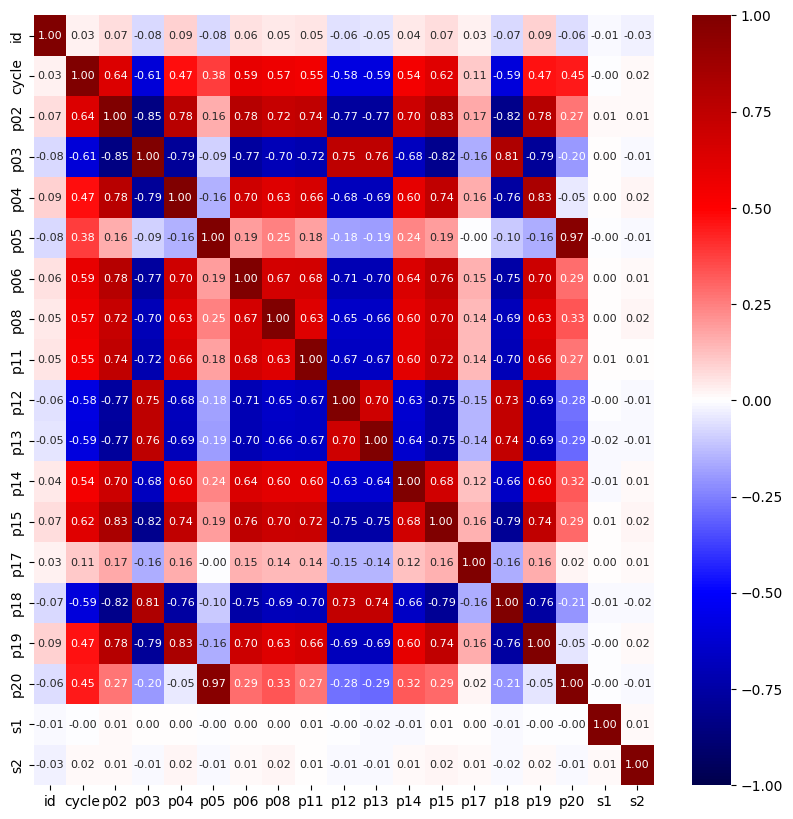

In [13]:
fig, ax = plt.subplots(figsize=(10, 10))
_ = sns.heatmap(df_drop.corr(), ax=ax, cmap='seismic', vmin=-1, vmax=1, annot=True, annot_kws={'fontsize': 8}, fmt=".2f")

### Plot some features

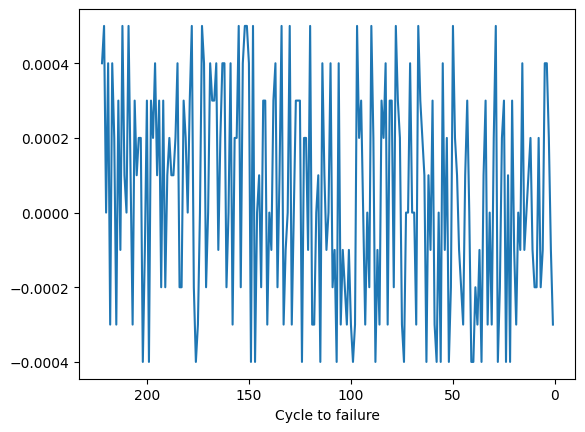

In [14]:
plot_feature(df, 's2', timeseries=[10])

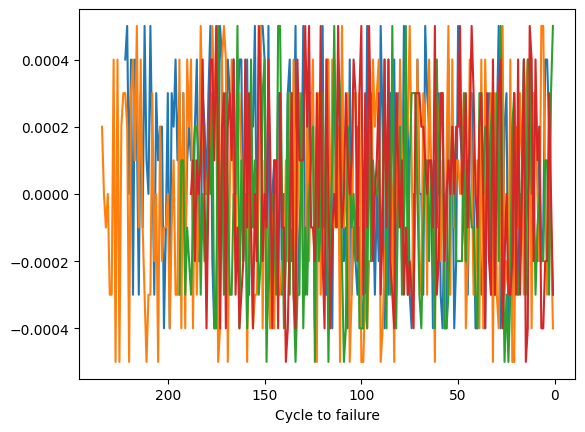

In [15]:
plot_feature(df, 's2', timeseries=[10, 20, 30, 40])

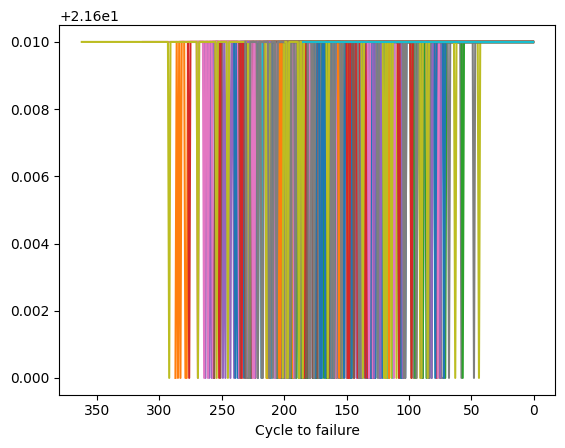

In [16]:
plot_feature(df, 'p17')

In [17]:
df.p17.unique()

array([21.61, 21.6 ])

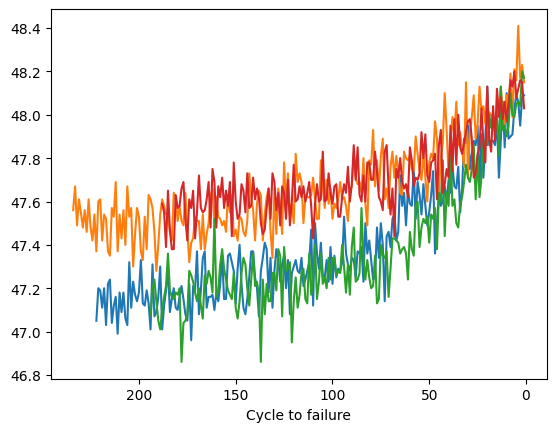

In [18]:
plot_feature(df, 'p02', timeseries=[10, 20, 30, 40])

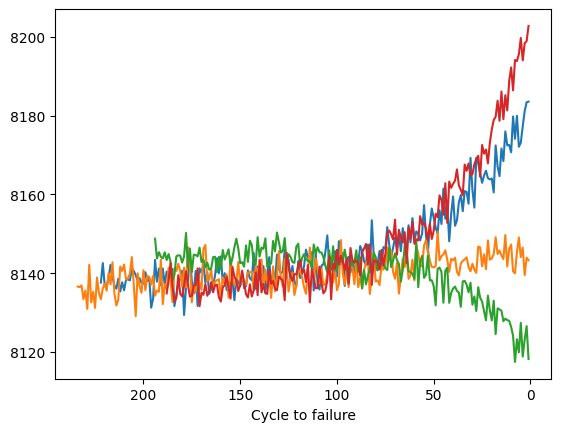

In [19]:
plot_feature(df, 'p05', timeseries=[10, 20, 30, 40])

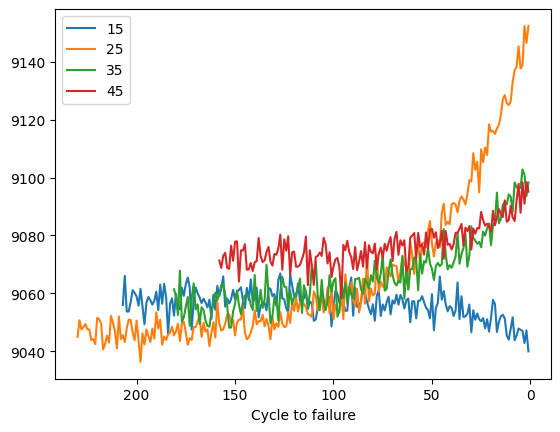

In [20]:
plot_feature(df, 'p20', timeseries=[15, 25, 35, 45], show_legend=True)

### EDA conclusions: 

- `p00`, `p01`, `p07`, `p09`, `p10`, `p16` are the constant values and should be removed.
- data scaling by each features are nessesary and should be standard.
- data of the different timeseries are consistent and could be same preprocessing.
- train-test split must be by timeseries and may be random.
- features are high-correlated. <b>features are not distributed independently</b>.
- bayesian method shouldn't work with this data. Other ML method may have some problems.
- `p05` and `p20` has a correlation value close to 1. One of them can be removed without losing much information.
- `p17` looks like a binary feature.
- `s1` and `s2` looks like a random noise.

## Problem statement

Business task. The business wants to predict the failure cycle in order to avoid failures. For example, to repair the engine before failure.
Business Hypothesis: Businesses will be happy if they know about the next failure within the next 30 cycles.
Let's formulate the ML problems in two way:
- regression problem to predict cycle before failure.
- classification problem to predict failure in last 30 cycles.

Add labels for each problem to dataset

In [21]:
# add regression label
timeseries_lenght = [df[df['id'] == i]['cycle'].max() for i in range(1, df.id.max() + 1)]
cycle_to_failure = []
for i in range(len(timeseries_lenght)):
    cycle_to_failure.extend(list(timeseries_lenght[i] + 1 - df['cycle'][df.id == i + 1]))
df['cycle_to_fail'] = cycle_to_failure

In [22]:
# add classification label
df['fail_next_30'] = np.where(df['cycle_to_fail'].to_numpy() <= 30, 1, 0)

#### Metrics

- Regression problem: TTF (MAE), number of timeseries with overstated predicted TTF.
- Classification problem: Precision, number of timeseries with understated predicted probabily. ROC-AUC and accuracy is not good metrics, because too many negative labels.

## Data preprocessing

Remove constant features

In [23]:
df_drop = df.drop(['p00', 'p01', 'p07', 'p09', 'p10', 'p16'], axis=1)

Remove one of highly correlated feature

In [24]:
df_drop = df_drop.drop(['p20'], axis=1)

Make `p17` is binary

In [25]:
df_drop['p17'] = np.where(df['p17'].to_numpy() > 21.605, 1., 0.)

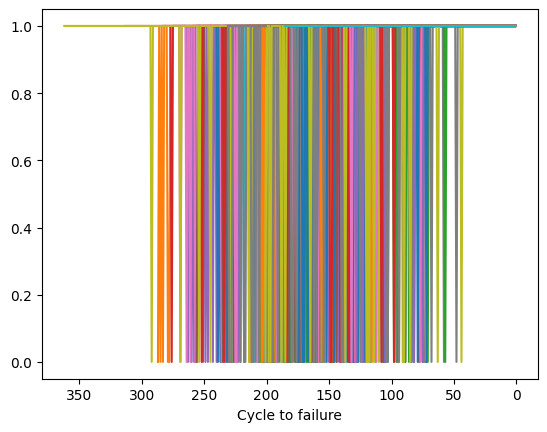

In [26]:
plot_feature(df_drop, 'p17')

In [27]:
df_drop

,id,cycle,p02,p03,p04,p05,p06,p08,p11,p12,p13,p14,p15,p17,p18,p19,s1,s2,cycle_to_fail,fail_next_30
0,1,1,47.47,521.66,2388.02,8138.62,8.4195,392,641.82,39.06,23.4190,1589.70,1400.60,1.0,554.36,2388.06,-0.0007,-0.0004,192,0
1,1,2,47.49,522.28,2388.07,8131.49,8.4318,392,642.15,39.00,23.4236,1591.82,1403.14,1.0,553.75,2388.04,0.0019,-0.0003,191,0
2,1,3,47.27,522.42,2388.03,8133.23,8.4178,390,642.35,38.95,23.3442,1587.99,1404.20,1.0,554.26,2388.08,-0.0043,0.0003,190,0
3,1,4,47.13,522.86,2388.08,8133.83,8.3682,392,642.35,38.88,23.3739,1582.79,1401.87,1.0,554.45,2388.11,0.0007,0.0000,189,0
4,1,5,47.28,522.19,2388.04,8133.80,8.4294,393,642.37,38.90,23.4044,1582.85,1406.22,1.0,554.00,2388.06,-0.0019,-0.0002,188,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16133,80,181,48.17,520.44,2388.17,8218.63,8.5194,397,644.00,38.39,23.1678,1604.26,1428.92,1.0,552.24,2388.20,0.0042,0.0002,5,1
16134,80,182,48.41,520.06,2388.12,8221.91,8.5493,396,643.81,38.34,23.0142,1598.32,1426.31,1.0,551.60,2388.16,-0.0014,0.0004,4,1
16135,80,183,48.04,519.67,2388.21,8217.46,8.5106,397,643.49,38.34,22.9337,1603.37,1434.30,1.0,551.78,2388.12,0.0018,0.0000,3,1
16136,80,184,48.04,519.72,2388.20,8228.65,8.4983,397,643.83,38.53,22.9971,1603.01,1430.23,1.0,551.78,2388.17,-0.0024,0.0002,2,1


Split to train and test

In [28]:
TRAIN_SPLIT_SIZE = .8

random_idx = np.random.permutation(np.arange(1, df.id.max() + 1))
train_idx = random_idx[:int(df.id.max() * TRAIN_SPLIT_SIZE)]
test_idx = random_idx[int(df.id.max() * TRAIN_SPLIT_SIZE):]

df_train = df_drop[df_drop['id'].isin(train_idx)]
df_test = df_drop[df_drop['id'].isin(test_idx)]

In [29]:
# train timeseries id
np.sort(train_idx)

array([ 1,  2,  3,  4,  5,  6,  7,  9, 10, 11, 12, 13, 14, 15, 17, 19, 20,
       21, 22, 23, 24, 25, 26, 27, 28, 30, 32, 33, 34, 35, 36, 39, 41, 42,
       43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 56, 59, 60, 61, 62,
       63, 64, 65, 66, 67, 68, 70, 73, 75, 76, 77, 78, 80], dtype=int64)

In [30]:
# test timeseries id
np.sort(test_idx)

array([ 8, 16, 18, 29, 31, 37, 38, 40, 55, 57, 58, 69, 71, 72, 74, 79],
      dtype=int64)

## Baseline Model

#### Regression task

In [40]:
X_regr_train = df_train.drop(['id', 'cycle_to_fail', 'fail_next_30'], axis=1)
y_regr_train = df_train['cycle_to_fail']
X_regr_test = df_test.drop(['id', 'cycle_to_fail', 'fail_next_30'], axis=1)
y_regr_test = df_test['cycle_to_fail']

In [41]:
# Normalize dataset
std_scaler = StandardScaler()
std_scaler.fit_transform(X_regr_train)
X_train_scaled = std_scaler.transform(X_regr_train)
X_test_scaled = std_scaler.transform(X_regr_test)

In [42]:
lr_regr = LinearRegression().fit(X_train_scaled, y_regr_train)
lr_regr.score(X_test_scaled, y_regr_test)

0.5092018306758588

In [43]:
lr_pred = lr_regr.predict(X_test_scaled)

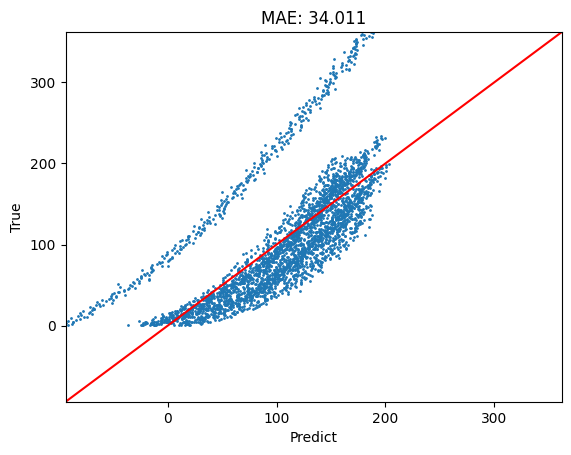

In [44]:
crossplot_pred(lr_pred, y_regr_test)

In [184]:
X_regr_test['predict'] = lr_pred
X_regr_test['id'] = df_test['id']  # return removed feature

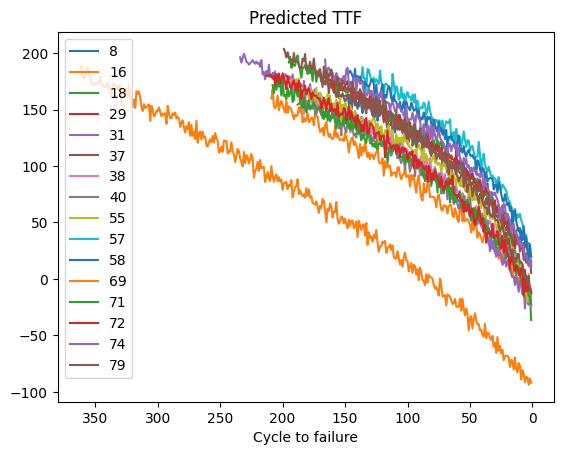

In [185]:
plot_feature(X_regr_test, 'predict', show_legend=True, title='Predicted TTF')

calculate mean predicted TTF at last 30 cycle of timeseries

In [191]:
X_regr_test['id'] = df_test['id']
X_regr_test['target'] = y_regr_test
X_regr_test[X_regr_test['target'] <= 30].groupby(by='id').mean()['predict'].sort_values()

id
69   -75.038642
31     2.768834
16     7.135032
71    12.258098
72    14.364149
38    17.325738
40    17.352605
55    21.278832
79    24.084719
18    24.944872
37    35.908808
29    40.162310
74    43.794821
8     45.038255
58    55.588515
57    60.772762
Name: predict, dtype: float64

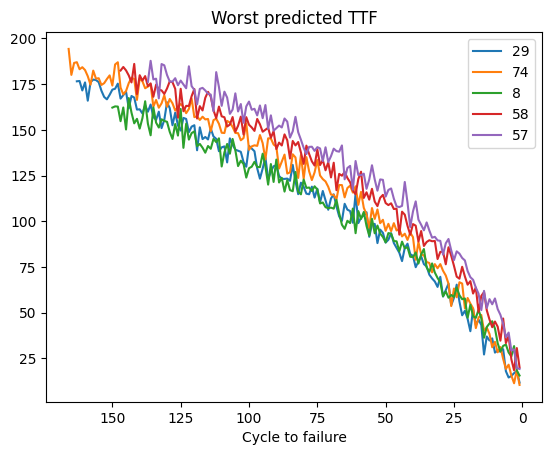

In [195]:
plot_feature(X_regr_test, 'predict', timeseries=[29, 74, 8, 58, 57], show_legend=True, title='Worst predicted TTF')

### Classification task

In [57]:
X_cls_train = df_train.drop(['id', 'cycle_to_fail', 'fail_next_30'], axis=1)
y_cls_train = df_train['fail_next_30']
X_cls_test = df_test.drop(['id', 'cycle_to_fail', 'fail_next_30'], axis=1)
y_cls_test = df_test['fail_next_30']

In [59]:
df_train

,id,cycle,p02,p03,p04,p05,p06,p08,p11,p12,p13,p14,p15,p17,p18,p19,s1,s2,cycle_to_fail,fail_next_30
0,1,1,47.47,521.66,2388.02,8138.62,8.4195,392,641.82,39.06,23.4190,1589.70,1400.60,1.0,554.36,2388.06,-0.0007,-0.0004,192,0
1,1,2,47.49,522.28,2388.07,8131.49,8.4318,392,642.15,39.00,23.4236,1591.82,1403.14,1.0,553.75,2388.04,0.0019,-0.0003,191,0
2,1,3,47.27,522.42,2388.03,8133.23,8.4178,390,642.35,38.95,23.3442,1587.99,1404.20,1.0,554.26,2388.08,-0.0043,0.0003,190,0
3,1,4,47.13,522.86,2388.08,8133.83,8.3682,392,642.35,38.88,23.3739,1582.79,1401.87,1.0,554.45,2388.11,0.0007,0.0000,189,0
4,1,5,47.28,522.19,2388.04,8133.80,8.4294,393,642.37,38.90,23.4044,1582.85,1406.22,1.0,554.00,2388.06,-0.0019,-0.0002,188,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16133,80,181,48.17,520.44,2388.17,8218.63,8.5194,397,644.00,38.39,23.1678,1604.26,1428.92,1.0,552.24,2388.20,0.0042,0.0002,5,1
16134,80,182,48.41,520.06,2388.12,8221.91,8.5493,396,643.81,38.34,23.0142,1598.32,1426.31,1.0,551.60,2388.16,-0.0014,0.0004,4,1
16135,80,183,48.04,519.67,2388.21,8217.46,8.5106,397,643.49,38.34,22.9337,1603.37,1434.30,1.0,551.78,2388.12,0.0018,0.0000,3,1
16136,80,184,48.04,519.72,2388.20,8228.65,8.4983,397,643.83,38.53,22.9971,1603.01,1430.23,1.0,551.78,2388.17,-0.0024,0.0002,2,1


In [60]:
# Normalize dataset
std_scaler = StandardScaler()
std_scaler.fit_transform(X_cls_test)
X_train_scaled = std_scaler.transform(X_cls_train)
X_test_scaled = std_scaler.transform(X_cls_test)

In [62]:
cls_regr = LogisticRegression(max_iter=1000).fit(X_train_scaled, y_cls_train)
cls_regr.score(X_test_scaled, y_cls_test)

0.9581202046035806

In [63]:
cls_pred = cls_regr.predict(X_test_scaled)
cls_pred_proba = cls_regr.predict_proba(X_test_scaled)

In [64]:
conf_matrix = metrics.confusion_matrix(y_cls_test, cls_pred)
true_negative = conf_matrix[0, 0]
true_positive = conf_matrix[1, 1]
false_negative = conf_matrix[0, 1]
false_positive = conf_matrix[1, 0]

In [65]:
recall = true_positive / (false_negative + true_positive)
precision = true_positive / (false_positive + true_positive)
print(f"Recall is {recall:.3f}, Precision is {precision:.3f}")

Recall is 0.897, Precision is 0.821


Plot predicted probability.

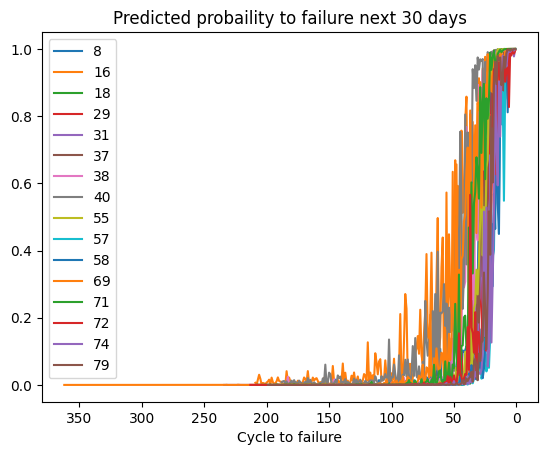

In [66]:
X_cls_test['predict'] = cls_pred_proba[:, 1]
X_cls_test['id'] = df_test['id']  # return removed feature
plot_feature(X_cls_test, 'predict', show_legend=True, title='Predicted probaility to failure next 30 days')

calculate mean predicted probabity at last 30 cycle of timeseries

In [196]:
X_cls_test['target'] = y_cls_test
X_cls_test[X_cls_test['target'] == 1].groupby(by='id').mean()['predict'].sort_values()

id
57    0.545457
58    0.582555
74    0.623752
72    0.673882
31    0.698066
79    0.700004
18    0.754559
29    0.770601
37    0.783128
8     0.854315
55    0.863082
69    0.916244
71    0.924259
16    0.946886
38    0.954430
40    0.975837
Name: predict, dtype: float64

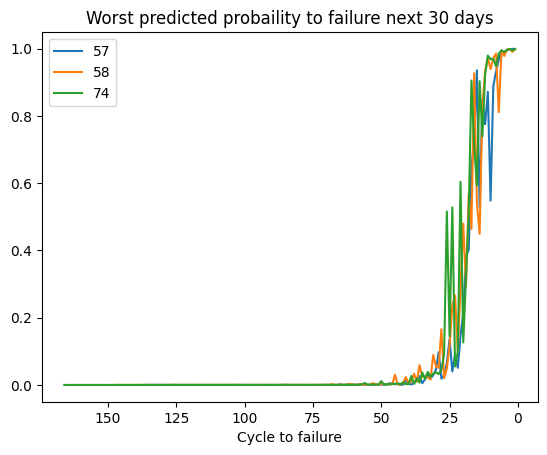

In [75]:
plot_feature(X_cls_test, 'predict', timeseries=[57, 58, 74], show_legend=True, title='Worst predicted probaility to failure next 30 days')

#### Baseline conclusion
##### Regression task
- linear regression has TTF MAE value is 34.
- 3 out of 16 engine test series have TTFs greater than 50 cycles, but the actual life cycle is less than 25.
- this will cause the engine to fail until it is stopped for repairs.
##### Classification task
- precision is 0.821.
- logistic regression have nervous cycle-to-cycle predicted probabity. Operator of ML system will not trust this prediction and could be ignore it.

## Transformers

Ideas: 
- Using the transformers architecture.
- Pass engine parameters for the last 30 cycles to the model and predict TTF and failure within 30 days.
- Add unsymmetrical losses to prevent predicting less than the real life cycle.

In [782]:
# normalize data
X_train = df_train.drop(['id', 'cycle_to_fail', 'fail_next_30'], axis=1)
y_regr_train = df_train['cycle_to_fail']
y_cls_train = df_train['fail_next_30']
X_test = df_test.drop(['id', 'cycle_to_fail', 'fail_next_30'], axis=1)
y_regr_test = df_test['cycle_to_fail']
y_cls_test = df_test['fail_next_30']

std_scaler = MinMaxScaler()
std_scaler.fit_transform(X_train)
X_train_scaled = std_scaler.transform(X_train)
X_test_scaled = std_scaler.transform(X_test)

In [853]:
BATCH_SIZE = 256
LR = 0.01
WEIGHT_DECAY = 1.0
N_EPOCHS = 60
WINDOW_SIZE = 30

In [810]:
# create dataloader
train_dataloader, ds = create_dataloader(df_train, X_train_scaled, y_regr_train, batch_size=BATCH_SIZE, window_size=WINDOW_SIZE)
test_dataloader, _ = create_dataloader(df_test, X_test_scaled, y_regr_test, batch_size=BATCH_SIZE, window_size=WINDOW_SIZE, shuffle=False, drop_last=False)

In [804]:
len(ds.index)

11153

In [728]:
from torch import nn

In [899]:
class TimeSeriesTransformer(nn.Module):
    def __init__(self, d_model=17, window_size=30, nhead=1, num_encoder_layers=2, dim_feedforward=16, dropout=0.2, add_softmax=False):
        super().__init__()
        layers = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout,
                                            batch_first=True)
        self.encoder = nn.TransformerEncoder(layers, num_layers=num_encoder_layers)
        self.linear = nn.Linear(dim_feedforward, 1)
        self.sigmoid = nn.Sigmoid()
        if add_softmax:
            self.softmax = nn.Softmax()
        # self.linear_1 = nn.Linear(d_model, 1)
        # self.linear_2 = nn.Linear(window_size, 1)
        
        self.d_model = d_model
        self.window_size = window_size
        self.add_softmax = add_softmax

    def forward(self, x):
        x = self.encoder(x)
        print(x.shape)
        # x = x.view(-1, self.d_model * self.window_size)
        x = self.sigmoid(x)
        x = self.linear(x)
        if self.add_softmax:
            x = self.softmax(x)            
        return x

In [844]:
class TimeSeriesTransformer(nn.Module):
    def __init__(self, d_model=17, window_size=30, nhead=1, num_layers=2, dim_feedforward=16, dropout=0.2, add_softmax=False):
        super().__init__()

        self.tf_model = nn.Transformer(d_model, nhead=nhead, num_encoder_layers=num_layers, num_decoder_layers=num_layers,
                                      dim_feedforward=dim_feedforward, dropout=dropout, batch_first=True)
        self.linear = nn.Linear(d_model * (window_size - 1), 1)
        # self.sigmoid = nn.Sigmoid()
        if add_softmax:
            self.softmax = nn.Softmax()
        # self.linear_1 = nn.Linear(d_model, 1)
        # self.linear_2 = nn.Linear(window_size, 1)
        
        self.d_model = d_model
        self.window_size = window_size
        self.add_softmax = add_softmax

    def forward(self, x, next_x):
        x = self.tf_model(x, next_x)
        x = x.view(-1, self.d_model * (self.window_size - 1))
        # x = self.sigmoid(x)
        x = self.linear(x)
        if self.add_softmax:
            x = self.softmax(x)            
        return x

In [714]:
class AutoEncoder(nn.Module):
    def __init__(self, d_model=17, window_size=30, add_softmax=False):
        super().__init__()
        layers = []
        activation = nn.Sigmoid
        layers.append(nn.Linear(d_model * window_size, int(d_model * window_size // 4)))
        layers.append(nn.BatchNorm1d(int(d_model * window_size // 4)))
        layers.append(activation())
        # layers.append(nn.Linear(int(d_model * window_size // 2), int(d_model * window_size // 4)))
        # layers.append(nn.BatchNorm1d(int(d_model * window_size // 4)))
        # layers.append(activation())
        # layers.append(nn.Linear(int(d_model * window_size // 4), int(d_model * window_size // 2)))
        # layers.append(nn.BatchNorm1d(int(d_model * window_size // 2)))
        # layers.append(activation())
        layers.append(nn.Linear(int(d_model * window_size // 4), int(d_model * window_size // 2)))
        layers.append(nn.BatchNorm1d(int(d_model * window_size // 2)))
        layers.append(activation())
        layers.append(nn.Linear(int(d_model * window_size // 2), 1))
        self.model = nn.Sequential(*layers)

        if add_softmax:
            self.softmax = nn.Softmax()
        # self.linear_1 = nn.Linear(d_model, 1)
        # self.linear_2 = nn.Linear(window_size, 1)
        
        self.d_model = d_model
        self.window_size = window_size
        self.add_softmax = add_softmax

    def forward(self, x):
        x = x.view(-1, self.d_model * self.window_size)
        x = self.model(x)
        return x

In [785]:
class Simple(nn.Module):
    def __init__(self, d_model=17, window_size=1, add_softmax=False, dropout=.2):
        super().__init__()
        layers = []
        activation = nn.Sigmoid
        layers.append(nn.Linear(d_model * window_size, 1))
        # layers.append(nn.Dropout(dropout))
        # layers.append(activation())
        self.model = nn.Sequential(*layers)

        if add_softmax:
            self.softmax = nn.Softmax()
        # self.linear_1 = nn.Linear(d_model, 1)
        # self.linear_2 = nn.Linear(window_size, 1)
        
        self.d_model = d_model
        self.window_size = window_size
        self.add_softmax = add_softmax

    def forward(self, x):
        x = x.view(-1, self.d_model * self.window_size)
        x = self.model(x)
        return x

In [900]:
model = TimeSeriesTransformer(d_model=17, nhead=1, num_encoder_layers=6, dim_feedforward=64, dropout=0.4, window_size=WINDOW_SIZE)

In [864]:
model = TimeSeriesTransformer(d_model=17, nhead=1, num_layers=1, dim_feedforward=32, dropout=0.1, window_size=WINDOW_SIZE)

In [715]:
model = AutoEncoder(d_model=17, window_size=WINDOW_SIZE)

In [795]:
model = Simple(d_model=17, window_size=WINDOW_SIZE)

In [901]:
optimizer = torch.optim.AdamW(params=model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
# criterion = create_unsymetric_mse()
criterion = nn.MSELoss()

In [902]:
def train(model, n_epochs, train_dataloader, optimizer, criterion, test_dataloader=None, verbose=True):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    train_loss = []
    test_loss = []
    ttf_mae = []
    train_ttf_list = []
    for epoch in range(1, n_epochs + 1):
        start_time = time.time()
        model.train()
        loss_list = []
        ttf_list = []
        for data, target in train_dataloader:
            # print(data.shape)
            data = data.to(device)
            target = torch.unsqueeze(target, 1).to(device)
            predict = model(data)
            # predict = model(data[:, :-1, :], data[:, 1:, :])
            # print(target.shape, predict.shape)
            loss = criterion(predict, target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_list.append(loss.detach().cpu().mean())
            ttf_list.append(torch.abs(predict - target).detach().cpu().mean())
        train_loss.append(np.array(loss_list).mean())
        train_ttf_list.append(np.array(ttf_list).mean())
        
        # break
        
        if n_epochs % 20 == 1:  # needs for decrease outputs
            IPython.display.clear_output()

        model.eval()
        if test_dataloader is not None:
            test_loss_list = []
            ttf_list = []
            for data, target in test_dataloader:
                data = data.to(device)
                target = target.to(device)
                predict = model(data)
                # predict = model(data[:, :-1, :], data[:, 1:, :])
                test_loss_list.append(criterion(predict, target).detach().cpu().mean())
                ttf_list.append(torch.abs(predict - target).detach().cpu().mean())
            test_loss.append(np.array(test_loss_list).mean())
            ttf_mae.append(np.array(ttf_list).mean())

        if verbose:
            print(f'epoch: {epoch}/{n_epochs}, '
                  f'train_loss: {train_loss[-1]:.3f}, '
                  f'train_ttf_mae: {train_ttf_list[-1]:.3f}, '
                  f'test_loss: {test_loss[-1]:.3f}, '
                  f'test_ttf_mae: {ttf_mae[-1]:.3f}, '
                  f'Time: {time.time() - start_time:.3f}')

In [903]:
train(model, N_EPOCHS, train_dataloader, optimizer, criterion, test_dataloader=test_dataloader)

torch.Size([512, 30, 17])


RuntimeError: mat1 and mat2 shapes cannot be multiplied (15360x17 and 64x1)

## Conclusions